In [1]:
# Importar modulos a emplear
import pandas as pd
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch


# Agregar la carpeta raíz del proyecto a las rutas de búsqueda de Python
base_dir = os.getcwd()  # Obtiene el directorio actual (donde está la libreta)
sys.path.append(base_dir)  # Agrega la carpeta raíz del proyecto a las rutas de búsqueda

# Definir la ruta base y cargar los datos limpios
base_dir = os.getcwd()
procesados_dir = os.path.join(base_dir, "data", "procesados")

In [2]:
# Comprobación y configuración del dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA está disponible. Los modelos pueden ser entrenados en GPU.")
    print("Cantidad de GPUs disponibles:", torch.cuda.device_count())
    print("Nombre de la GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA no está disponible. Los modelos serán entrenados en CPU.")

CUDA está disponible. Los modelos pueden ser entrenados en GPU.
Cantidad de GPUs disponibles: 1
Nombre de la GPU: NVIDIA GeForce RTX 4060 Ti


# Importamos el dato limpio

In [3]:
# Cargar los datos limpios
ventas_df = pd.read_csv(os.path.join(procesados_dir, "ventas_limpio.csv"))
productos_df = pd.read_csv(os.path.join(procesados_dir, "productos_limpio.csv"))
ciudad_df = pd.read_csv(os.path.join(procesados_dir, "ciudad_limpio.csv"))

# Union de tablas

In [4]:
# Unir las tablas
# Unir ventas con productos (por Cod_Producto)
ventas_productos = pd.merge(ventas_df, productos_df, on="cod_producto")

# Unir el resultado con ciudad (por Cod_Ciudad)
ventas_completa = pd.merge(ventas_productos, ciudad_df, on="cod_ciudad")

# Calcular ingresos, costos y beneficios
ventas_completa["Ingresos"] = ventas_completa["precio_unitario"] * ventas_completa["unidades_vendidas"]
ventas_completa["Costo_Total"] = (
    (ventas_completa["costo_unitario"] * ventas_completa["unidades_vendidas"])
    + ventas_completa["costo_asociado_al_domicilio"]
)
ventas_completa["Beneficio"] = ventas_completa["Ingresos"] - ventas_completa["Costo_Total"]

# Asegúrate de que la columna de fechas esté en formato datetime
ventas_completa["fecha_orden"] = pd.to_datetime(ventas_completa["fecha_orden"])

# Edición de los datos

In [5]:
# Agrupar los datos por fecha y calcular el total de beneficio diario
beneficios_diarios = ventas_completa.groupby("fecha_orden")["Beneficio"].sum().reset_index()

In [6]:
# Crear un rango completo de fechas
rango_fechas = pd.date_range(
    start=beneficios_diarios["fecha_orden"].min(),
    end=beneficios_diarios["fecha_orden"].max(),
    freq="D"
)

# Reindexar para asegurarte de que todas las fechas estén presentes
beneficios_diarios = beneficios_diarios.set_index("fecha_orden").reindex(rango_fechas, fill_value=0).reset_index()
beneficios_diarios.columns = ["fecha_orden", "beneficio"]

In [7]:
# Crear lags (valores de días anteriores)
for lag in range(1, 8):  # Lags de 1 a 7 días
    beneficios_diarios[f"lag_{lag}"] = beneficios_diarios["beneficio"].shift(lag)

In [8]:
# Crear medias móviles
beneficios_diarios["media_movil_3"] = beneficios_diarios["beneficio"].rolling(window=3).mean()
beneficios_diarios["media_movil_7"] = beneficios_diarios["beneficio"].rolling(window=7).mean()

In [9]:
# Extraer características temporales
beneficios_diarios["mes"] = beneficios_diarios["fecha_orden"].dt.month
beneficios_diarios["dia_mes"] = beneficios_diarios["fecha_orden"].dt.day
beneficios_diarios["dia_semana"] = beneficios_diarios["fecha_orden"].dt.weekday  # 0 = Lunes, 6 = Domingo
beneficios_diarios["es_fin_de_semana"] = beneficios_diarios["dia_semana"].isin([5, 6]).astype(int)

In [10]:
# Extraer variación porcentual diaria
beneficios_diarios["variacion_diaria"] = beneficios_diarios["beneficio"].pct_change()

In [11]:
# Rellenar NaN con 0 o forward-fill para medias móviles y variaciones
beneficios_diarios.fillna(0, inplace=True)

In [12]:
beneficios_diarios.columns

Index(['fecha_orden', 'beneficio', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'media_movil_3', 'media_movil_7', 'mes', 'dia_mes',
       'dia_semana', 'es_fin_de_semana', 'variacion_diaria'],
      dtype='object')

In [13]:
beneficios_diarios.describe()

,fecha_orden,beneficio,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,media_movil_3,media_movil_7,mes,dia_mes,dia_semana,es_fin_de_semana,variacion_diaria
count,91,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.00000,91.000000,91.000000
mean,2024-02-15 00:00:00,246202.747253,242180.329670,239302.527473,237028.241758,233495.274725,228840.109890,225815.274725,224826.703297,240501.318681,229348.649922,2.000000,15.681319,3.00000,0.285714,0.134059
min,2024-01-01 00:00:00,83030.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.000000,-0.686485
25%,2024-01-23 12:00:00,186480.000000,181450.000000,177235.000000,174860.000000,170650.000000,166535.000000,166350.000000,166350.000000,202203.333333,213527.142857,1.000000,8.000000,1.00000,0.000000,-0.300829
50%,2024-02-15 00:00:00,239580.000000,239300.000000,235050.000000,235050.000000,234040.000000,228750.000000,223560.000000,223560.000000,241516.666667,239912.857143,2.000000,16.000000,3.00000,0.000000,-0.023214
75%,2024-03-08 12:00:00,297580.000000,293000.000000,293000.000000,293000.000000,289275.000000,287795.000000,287795.000000,287795.000000,280411.666667,265807.142857,3.000000,23.000000,5.00000,1.000000,0.405137
max,2024-03-31 00:00:00,493270.000000,493270.000000,493270.000000,493270.000000,493270.000000,493270.000000,493270.000000,493270.000000,364270.000000,318104.285714,3.000000,31.000000,6.00000,1.000000,2.074792
std,NaN,86867.657120,89685.967358,93180.299713,96446.883327,99168.273257,100082.842857,102787.383719,104526.398229,64386.056835,70131.262634,0.829993,8.825316,2.01108,0.454257,0.595264


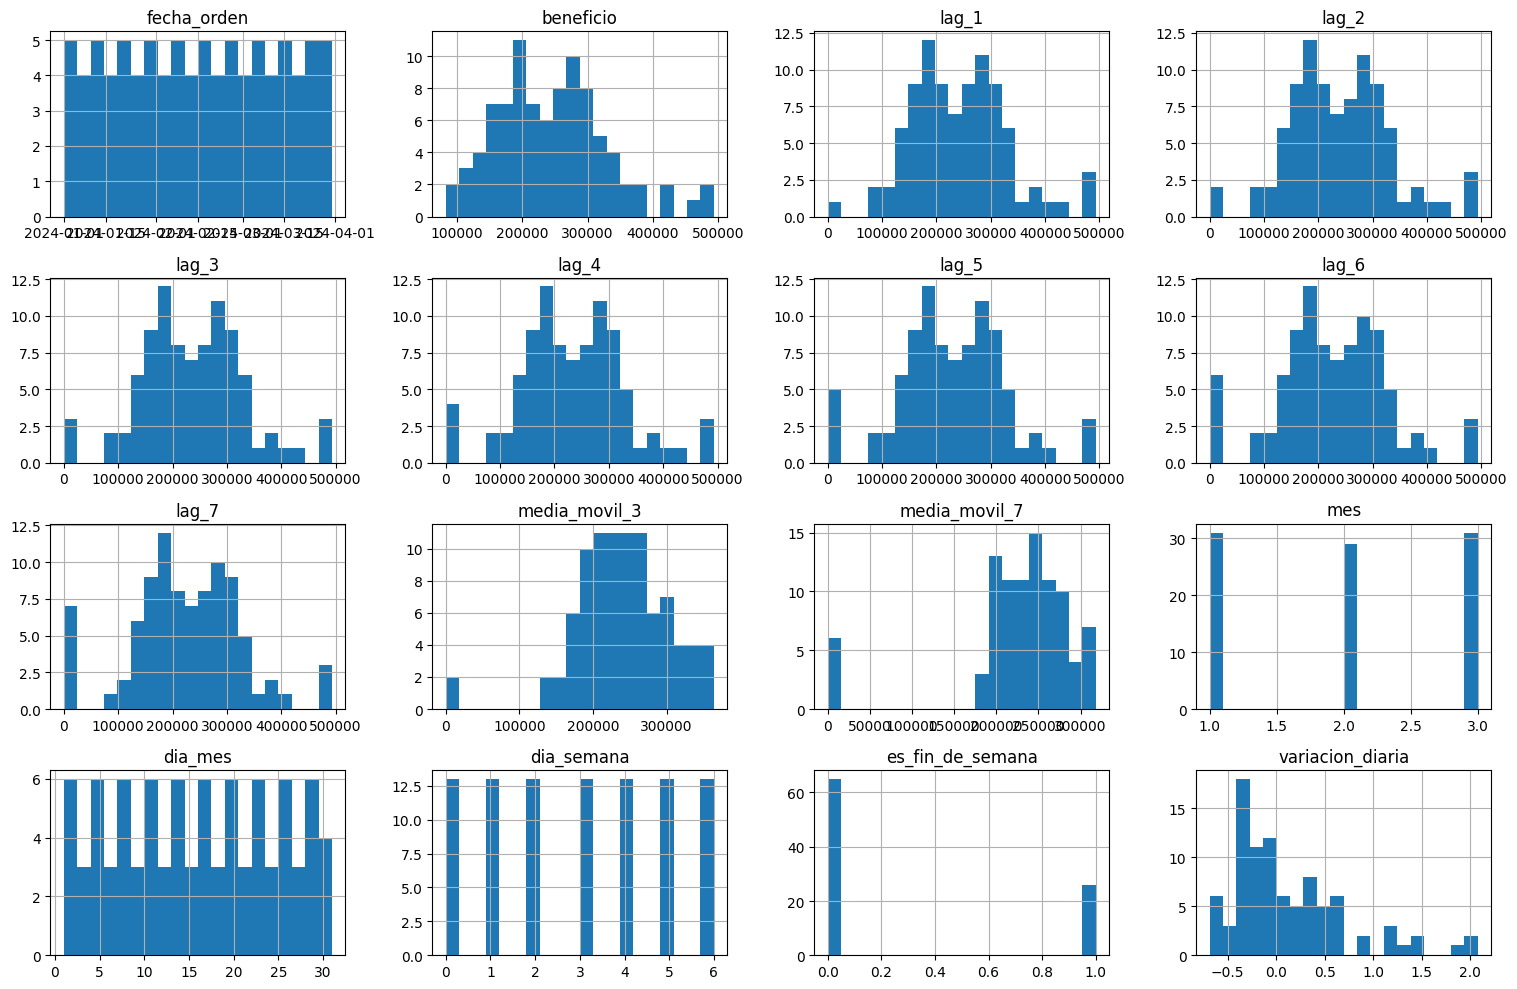

In [14]:
import matplotlib.pyplot as plt
beneficios_diarios.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler


# Definir las columnas a normalizar
columnas_a_normalizar = ["beneficio", "lag_1", "lag_2", "lag_3", "lag_4", 
                         "lag_5", "lag_6", "lag_7", "media_movil_3", 
                         "media_movil_7", "variacion_diaria"]

# Separar las columnas categóricas y binarias
columnas_categoricas = ["mes", "dia_mes", "dia_semana", "es_fin_de_semana"]

# Aplicar normalización solo a las columnas continuas
scaler = MinMaxScaler()
beneficios_diarios_normalizados = beneficios_diarios.copy()
beneficios_diarios_normalizados[columnas_a_normalizar] = scaler.fit_transform(
    beneficios_diarios[columnas_a_normalizar]
)

# Modelo

In [17]:
def preparar_datos_lstm(data, target_col, lag=7):
    """
    Prepara los datos en formato de secuencias para LSTM.

    Args:
        data (pd.DataFrame): DataFrame con las características.
        target_col (str): Nombre de la columna objetivo.
        lag (int): Número de pasos rezagados (ventana deslizante).

    Returns:
        tuple: X (características), y (objetivo).
    """
    X, y = [], []
    for i in range(lag, len(data)):
        # Seleccionar la ventana deslizante para X
        X.append(data.iloc[i-lag:i].values)
        # Seleccionar SOLO la columna objetivo para y
        y.append(data.iloc[i][target_col])  # No debería incluir más de una columna
    return np.array(X), np.array(y)

In [23]:
# Crear ventanas deslizantes
columnas_modelo = columnas_a_normalizar + ["mes", "dia_mes", "dia_semana", "es_fin_de_semana"]
X, y = preparar_datos_lstm(beneficios_diarios_normalizados[columnas_modelo + ["beneficio"]], 
                           target_col="beneficio", lag=7)

# Verificar dimensiones
print("Dimensiones de X:", X.shape)  # (n_secuencias, lag, n_características)
print("Dimensiones de y:", y.shape)  # (n_secuencias,)

Dimensiones de X: (84, 7, 16)
Dimensiones de y: (84, 2)


In [25]:
# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Verificar dimensiones
print("Dimensiones de X_train:", X_train.shape)  # (n_secuencias, lag, n_características)
print("Dimensiones de y_train:", y_train.shape)  # (n_secuencias,)

Dimensiones de X_train: (67, 7, 16)
Dimensiones de y_train: (67, 2)


In [20]:
# Verificar dimensiones
print("Dimensiones de X_train:", X_train.shape)  # (n_secuencias, lag, n_características)
print("Dimensiones de y_train:", y_train.shape)  # (n_secuencias, 1)

Dimensiones de X_train: (67, 7, 16)
Dimensiones de y_train: (67, 2)


In [26]:
# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Asegurar forma correcta
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Verificar dimensiones nuevamente
print("Dimensiones de X_train:", X_train.shape)  # (n_secuencias, lag, n_características)
print("Dimensiones de y_train:", y_train.shape)  # (n_secuencias, 1)

Dimensiones de X_train: torch.Size([67, 7, 16])
Dimensiones de y_train: torch.Size([134, 1])


In [23]:
# Definir el modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Salida para un valor (beneficio)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Usar la última salida de la secuencia
        return out

# Configurar modelo
input_size = X_train.shape[2]  # Número de características
hidden_size = 50
num_layers = 2

# Instanciar el modelo
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

In [24]:
# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenar el modelo
epochs = 100
for epoch in range(epochs):
    model.train()
    X_train, y_train = X_train.to(device), y_train.to(device)
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

f:\Python\Entrevistas\modelo\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([134, 1])) that is different to the input size (torch.Size([67, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (67) must match the size of tensor b (134) at non-singleton dimension 0

In [25]:
# Asegurarnos de que los datos estén en formato de tensores
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Evaluar el modelo
model.eval()
with torch.no_grad():
    X_test, y_test = X_test.to(device), y_test.to(device)
    predictions = model(X_test).cpu().numpy()
    y_test = y_test.cpu().numpy()
    
rmse = root_mean_squared_error(y_test, predictions)
print(f"RMSE: {rmse:.2f}")

RMSE: 276862.31


C:\Users\ingen\AppData\Local\Temp\ipykernel_26832\504628922.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


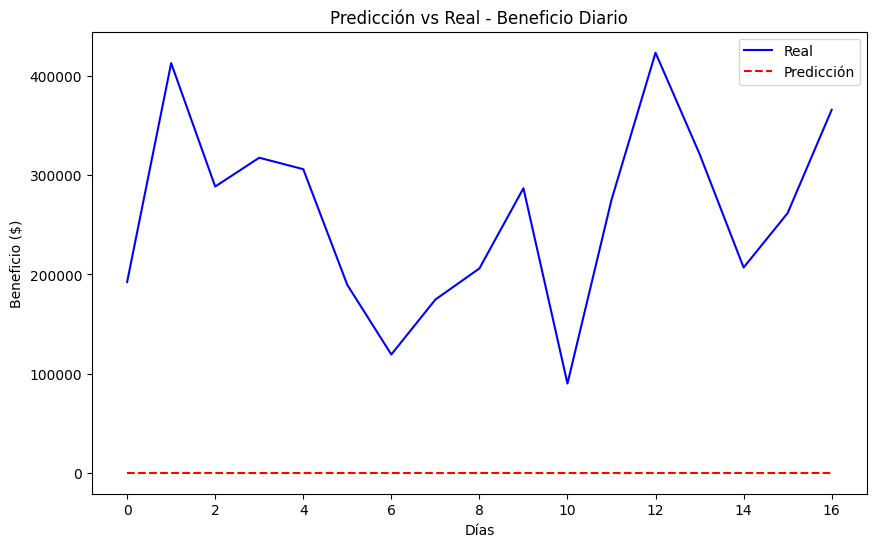

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Real", color="blue")
plt.plot(predictions, label="Predicción", color="red", linestyle="--")
plt.title("Predicción vs Real - Beneficio Diario")
plt.xlabel("Días")
plt.ylabel("Beneficio ($)")
plt.legend()
plt.show()